In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob


In [2]:
# Enrolment
enrol_df = pd.concat(
    [pd.read_csv(f) for f in glob.glob("../data/api_data_aadhar_enrolment/*.csv")],
    ignore_index=True
)
enrol_df["total_enrolment"] = (
    enrol_df["age_0_5"] + enrol_df["age_5_17"] + enrol_df["age_18_greater"]
)
state_enrol = enrol_df.groupby("state")["total_enrolment"].sum().reset_index()

# Demographic updates
demo_df = pd.concat(
    [pd.read_csv(f) for f in glob.glob("../data/api_data_aadhar_demographic/*.csv")],
    ignore_index=True
)
demo_age_cols = [c for c in demo_df.columns if c.startswith("demo_age")]
demo_df["total_demo_updates"] = demo_df[demo_age_cols].sum(axis=1)
state_demo = demo_df.groupby("state")["total_demo_updates"].sum().reset_index()

# Biometric updates
bio_df = pd.concat(
    [pd.read_csv(f) for f in glob.glob("../data/api_data_aadhar_biometric/*.csv")],
    ignore_index=True
)
bio_age_cols = [c for c in bio_df.columns if c.startswith("bio_age")]
bio_df["total_bio_updates"] = bio_df[bio_age_cols].sum(axis=1)
state_bio = bio_df.groupby("state")["total_bio_updates"].sum().reset_index()

# Merge
df = (
    state_enrol
    .merge(state_demo, on="state", how="left")
    .merge(state_bio, on="state", how="left")
)

df.fillna(0, inplace=True)
df["total_updates"] = df["total_demo_updates"] + df["total_bio_updates"]
df.head()


,state,total_enrolment,total_demo_updates,total_bio_updates,total_updates
0,100000,218,2.0,0.0,2.0
1,Andaman & Nicobar Islands,114,1059.0,2384.0,3443.0
2,Andaman and Nicobar Islands,397,6187.0,18314.0,24501.0
3,Andhra Pradesh,127681,2295505.0,3714592.0,6010097.0
4,Arunachal Pradesh,4344,36443.0,72394.0,108837.0


In [3]:
# Update Pressure Ratio
df["UPR"] = df["total_updates"] / df["total_enrolment"]

# Expected updates (national baseline)
expected_ratio = df["total_updates"].sum() / df["total_enrolment"].sum()
df["expected_updates"] = df["total_enrolment"] * expected_ratio

# ARGI
df["ARGI"] = df["total_updates"] / df["expected_updates"]

df.head()


,state,total_enrolment,total_demo_updates,total_bio_updates,total_updates,UPR,expected_updates,ARGI
0,100000,218,2.0,0.0,2.0,0.009174,4.774855e+03,0.000419
1,Andaman & Nicobar Islands,114,1059.0,2384.0,3443.0,30.201754,2.496942e+03,1.378886
2,Andaman and Nicobar Islands,397,6187.0,18314.0,24501.0,61.715365,8.695492e+03,2.817667
3,Andhra Pradesh,127681,2295505.0,3714592.0,6010097.0,47.071193,2.796597e+06,2.149075
4,Arunachal Pradesh,4344,36443.0,72394.0,108837.0,25.054558,9.514665e+04,1.143887


In [4]:
df["anomaly_flag"] = "Normal"

df.loc[df["ARGI"] > 1.3, "anomaly_flag"] = "Very High Update Stress"
df.loc[df["UPR"] > df["UPR"].quantile(0.9), "anomaly_flag"] = "High Update Pressure"
df.loc[df["ARGI"] < 0.7, "anomaly_flag"] = "Low Update Utilization"

df["anomaly_flag"].value_counts()


anomaly_flag
Very High Update Stress    20
Normal                     20
Low Update Utilization      9
High Update Pressure        6
Name: count, dtype: int64

In [5]:
anomalies = df[df["anomaly_flag"] != "Normal"] \
    .sort_values("ARGI", ascending=False)

anomalies[["state", "total_enrolment", "total_updates", "UPR", "ARGI", "anomaly_flag"]].head(10)


,state,total_enrolment,total_updates,UPR,ARGI,anomaly_flag
12,Daman & Diu,21,2829.0,134.714286,6.150494,High Update Pressure
33,ODISHA,1,84.0,84.000000,3.835091,High Update Pressure
13,Daman and Diu,120,8315.0,69.291667,3.163569,High Update Pressure
48,WESTBENGAL,1,69.0,69.000000,3.150253,High Update Pressure
2,Andaman and Nicobar Islands,397,24501.0,61.715365,2.817667,High Update Pressure
7,Chandigarh,2723,157843.0,57.966581,2.646513,High Update Pressure
3,Andhra Pradesh,127681,6010097.0,47.071193,2.149075,Very High Update Stress
8,Chhattisgarh,103219,4654163.0,45.090177,2.058630,Very High Update Stress
10,Dadra and Nagar Haveli,744,33268.0,44.715054,2.041503,Very High Update Stress
15,Goa,2333,103517.0,44.370767,2.025785,Very High Update Stress


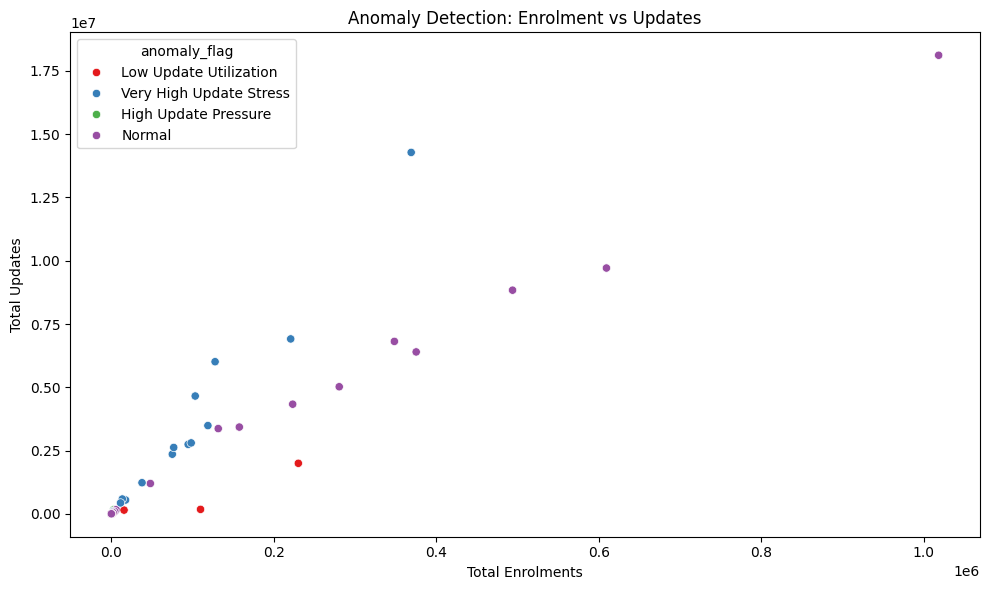

In [6]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="total_enrolment",
    y="total_updates",
    hue="anomaly_flag",
    palette="Set1"
)

plt.title("Anomaly Detection: Enrolment vs Updates")
plt.xlabel("Total Enrolments")
plt.ylabel("Total Updates")
plt.tight_layout()
plt.show()
